<a href="https://colab.research.google.com/github/aerjayc/coe197z-hw2/blob/master/mnist_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.


In [0]:
def corrupt_mnist_img(rng, img, value):
    """Corrupt a single MNIST image.
    Note that the image itself is MODIFIED.
    :param rng: instance of numpy.random.RandomState
    :param img: image to modify. ndarray or compatible
    :param value: pixel value to use for corrupting the image
    :return: modified image
    """
    # Choose square size
    s = rng.randint(7, 15)
    # Choose top-left corner position
    x = rng.randint(0, 29 - s)
    y = rng.randint(0, 29 - s)
    # Draw square
    img[..., y:y + s, x:x + s] = value
    # Return object for convenience
    return img


def corrupt_mnist_copy(x_train, value=255, seed=0):
    """Create a corrupted copy of the MNIST dataset
    :param x_train: ndarray of images. Shape: (N, ..., H, W)
    :param value: pixel value to use for corrupting the image
    :param seed: seed to use for the random number generator
    :return: ndarray of corrupted images
    :return: ndarray of corrupted images
    """
    rng = np.random.RandomState(seed)
    corrupted_x_train = x_train.copy()
    for img in corrupted_x_train:
        corrupt_mnist_img(rng, img, value)
    return corrupted_x_train


def corrupt_mnist_generator(x_train, value=255, seed=0):
    """Generator version of `corrupt_mnist_copy()`
    :param x_train:
    :param value:
    :param seed:
    :return:
    """
    rng = np.random.RandomState(seed)
    while True:
        for img in x_train:
            yield corrupt_mnist_img(rng, img.copy(), value)

In [0]:
# Import dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Corrupt images
x_train_corrupt = corrupt_mnist_copy(x_train)
x_test_corrupt  = corrupt_mnist_copy(x_test)

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train_corrupt = np.reshape(x_train_corrupt, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_test_corrupt = np.reshape(x_test_corrupt, [-1, image_size, image_size, 1])

x_train = x_train.astype('float32') / 255
x_train_corrupt = x_train_corrupt.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_test_corrupt = x_test_corrupt.astype('float32') / 255

x_train_noisy = x_train_corrupt
x_test_noisy = x_test_corrupt

11493376/11490434 [==============================] - 1s 0us/step





Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output

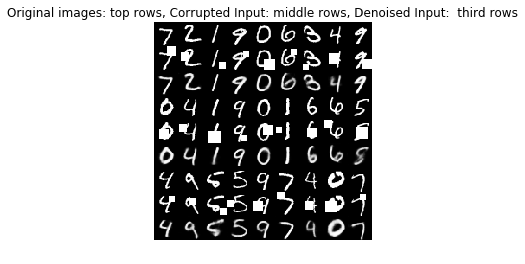

In [0]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size)

# predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# 3 sets of images with 9 MNIST digits
# 1st rows - original images
# 2nd rows - images corrupted by noise
# 3rd rows - denoised images
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()